<h1 align="center"> IST 5520 Milestone 3: Data Analysis I <h1>
<h3 align="center"> AirBnB Dataset <h3>

#### Student: Ronald Adomako
#### Student: Idris Dobbs
#### Student: Narendra Chigili
#### Student: Nikhil Srirama Sai

# Cleanse and visualize data

## Introduction

AirBnB is a PaaS for the short term rental market. Users use the platform to list residences for short term rentals. We noticed that for big cities, such as New York City, there are many host and some may want to use AirBnB for lucrative means. Given location and characteristics of a property, a new host would want to know whether he or she is charging the optimal amount to rent the space to lodgers.

We noticed that from the New York City dataset for AirBnB, the categorical variable for location  was too coarse. The descriptor says the location is categorized into five boroughs. For a big city such as New York City, there are a lot of insights missing from a business perspective because neighborhoods vary drastically in property amenities even within a single borough. Moreso, the geo-coordinates are too fine for business purposes. To handle this we implement a zip code converter to categorize properties based on their location - Feature Selection.

- What are the largest determinants / predictors of AirBnB rental prices?
- How can we optimize rental revenue based on rental location and other characteristics?
- What price should be charged based on rental location/ characteristics?

We are opperating under the assumption that NYC AirBnB prices has reached a *steady-state*: i.e. the market has been active for long enough in NYC and there are enough data points (observations) in NYC that the **mean** is meaningful.

We want to know whether a host is charging an optimal price. To do this we group the observations by neigborhood and then take the average price. Hosts who charge at or above this price are considered optimal in their respective neighborhood while hosts who charge below the average price for their neighborhood are sub-optimal. Consider the case where all hosts charge the same price within a neighborhood, then the mean is the mode is the median- uniform data, no variance. All the hosts in this neighborhood would be optimal.

Consider the case where one of those hosts charge below what would have been the average, then only that host is sub-optimal while the rest are optimal. Conversely, if one host charge above the rest while everyone else charges the same, then that one host would be optimal while the rest are suboptimal.

Along with the *steady-state* assumption, by grouping the data by neighborhoods we assume that on average homes and amenities are similar by neighborhood. The geo-coordinates are too fine a scale and the boroughs are too coarse a scale. A meso-scale would be by zipcode, which we would expect to have higher precision of similarities between host, or by neighborhood. For a dataset with 39881 observations, transforming geo-coordinates prove to be computationally expensive (22 hours on standard household computer). We chose the next best meso-scale: what AirBnB features as "neighbourhood".

From a business perspective, we want to know what percent of hosts per neighborhood are charging an optimal price, and aggregating this data the percent hosts charge an optimal price in NYC overall. We see that using the neighborhood grouping allows us to compare on a common scale for all hosts. We don't have hosts income, so we wouldn't be able to measure profit. Likewise, revenue wouldn't be a fair scale because hosts with more units will outperform host with smaller units just by volume. A nieghborhood comparison allows a better metric to assess price per room, where we expect reasonably small variance per neighborhood. Furthermore, comparing by percentage is normalizes our comparison in general.

## Data Source and Collection

#### We chose the AirBnB dataset for New York City (NYC). We want to build a model that indicates whether hosts are charging an optimum amount for their rental.

http://insideairbnb.com/new-york-city/

[data dictionary](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?usp=sharing)

http://insideairbnb.com/get-the-data

http://data.insideairbnb.com/united-states/ny/new-york-city/2022-09-07/visualisations/listings.csv



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sidetable as stb
import numpy as np
# import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
import seaborn as sb
from scipy import stats as st
import statsmodels as sts
import statsmodels.api as sm
import json
import folium

%matplotlib inline

In [2]:
data = pd.read_csv('/Users/palaparthisainikhil/Downloads/IST5520GrpProj-milestone3 2/Grp3Project_InitialData/data_dictionary.csv')
csv_URL = "http://data.insideairbnb.com/united-states/ny/new-york-city/2022-09-07/visualisations/listings.csv"
df2 = pd.read_csv(csv_URL)

In [3]:
data_dict = pd.DataFrame(df2.columns, columns=['Features'])
data_dict['Description']=None

In [4]:
d1=pd.read_csv("Brooklyn_zipcodes.csv")
d2=pd.read_csv("Manhattan_zipcodes.csv")
d = pd.concat([d1,d2])

In [5]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31692 entries, 0 to 16846
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      31692 non-null  int64  
 1   id                              31692 non-null  float64
 2   name                            31681 non-null  object 
 3   host_id                         31692 non-null  int64  
 4   host_name                       31642 non-null  object 
 5   neighbourhood_group             31692 non-null  object 
 6   neighbourhood                   31692 non-null  object 
 7   latitude                        31692 non-null  float64
 8   longitude                       31692 non-null  float64
 9   room_type                       31692 non-null  object 
 10  price                           31692 non-null  int64  
 11  minimum_nights                  31692 non-null  int64  
 12  number_of_reviews               

### Dimensional Analysis
- What are the largest determinants / predictors of AirBnB rental prices?

The data dictionary for New York City AirBnB dataset consists of 75 columns (variables or features) and 39881 observations. Based on our research question and several [Kaggle challenges](https://www.kaggle.com/search?q=airbnb-listing-in-nyc) (www.kaggle.com/search?q=airbnb-listing-in-nyc) we reduced our dimensions to the following **18** features for preliminary analysis.

In [6]:
for i,feature in enumerate(df2.columns):
    #print(feature)
    #print(type(feature))
    val = data[data['Field']==feature]['Description'].values
    try:
        data_dict.loc[i,'Description'] = val[0]
    except: #IndexError
        data_dict.loc[i,'Description'] = None
        
    if feature == 'neighbourhood':
        data_dict.loc[i,'Description'] = \
            'Neighborhood equivalent for zip code group'
    if feature == 'neighbourhood_group':
        data_dict.loc[i,'Description'] = \
            'Borough'        
        
pd.set_option('display.max_colwidth', 100)
data_dict


,Features,Description
0,id,Airbnb's unique identifier for the listing
1,name,Name of the listing
2,host_id,Airbnb's unique identifier for the host/user
3,host_name,Name of the host. Usually just the first name(s).
4,neighbourhood_group,Borough
5,neighbourhood,Neighborhood equivalent for zip code group
6,latitude,Uses the World Geodetic System (WGS84) projection for latitude and longitude.
7,longitude,Uses the World Geodetic System (WGS84) projection for latitude and longitude.
8,room_type,[Entire home/apt|Private room|Shared room|Hotel]
9,price,daily price in local currency


In [7]:
csv_URL = "http://data.insideairbnb.com/united-states/ny/new-york-city/2022-09-07/visualisations/listings.csv"
df = pd.read_csv(csv_URL)

## Data Manipulation

In [8]:
df['neighbourhood_group'].unique()

array(['Brooklyn', 'Queens', 'Bronx', 'Manhattan', 'Staten Island'],
      dtype=object)

In [9]:
#Create a data frame grouping by neighborhood for average price
hood_price_obj = df[['neighbourhood','price']].groupby('neighbourhood')
df_mean_price = hood_price_obj.mean()
df_mean_price[['price']] = df_mean_price[['price']].round(2)
df_mean_price

,price
neighbourhood,
Allerton,118.78
Arden Heights,113.86
Arrochar,132.06
Arverne,230.26
Astoria,109.01
...,...
Windsor Terrace,175.40
Woodhaven,94.53
Woodlawn,141.00


**We have reduced 39881 into 244 rows of manageable data!**

In [13]:
hood_price_objz = d[['ZipCodes','price','neighbourhood']].groupby('ZipCodes')
df_mean_pricez = hood_price_objz.mean()
df_mean_pricez[['price']] = df_mean_pricez[['price']].round(2)
df_mean_pricez

,price
ZipCodes,
10000.0,173.40
10001.0,312.69
10002.0,280.50
10003.0,258.39
10004.0,315.30
...,...
11238.0,206.36
11239.0,155.12
11249.0,245.05


In [14]:
df_mean_pricez.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 112 entries, 10000.0 to 11385.0
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   112 non-null    float64
dtypes: float64(1)
memory usage: 1.8 KB


In [15]:
df.stb.freq(['neighbourhood'])

,neighbourhood,count,percent,cumulative_count,cumulative_percent
0,Bedford-Stuyvesant,2779,6.968230,2779,6.968230
1,Williamsburg,2456,6.158321,5235,13.126551
2,Harlem,1878,4.709009,7113,17.835561
3,Midtown,1701,4.265189,8814,22.100750
4,Bushwick,1657,4.154861,10471,26.255610
...,...,...,...,...,...
239,Fort Wadsworth,1,0.002507,39877,99.989970
240,Ferry Point Park,1,0.002507,39878,99.992478
241,Country Club,1,0.002507,39879,99.994985
242,Bull's Head,1,0.002507,39880,99.997493


In [16]:
d.stb.freq(['ZipCodes'])

,ZipCodes,count,percent,cumulative_count,cumulative_percent
0,10019.0,1004,4.902583,1004,4.902583
1,10002.0,937,4.575419,1941,9.478002
2,10016.0,745,3.637873,2686,13.115875
3,10025.0,714,3.486498,3400,16.602373
4,10036.0,688,3.359539,4088,19.961912
...,...,...,...,...,...
107,10285.0,2,0.009766,20475,99.980468
108,10278.0,1,0.004883,20476,99.985351
109,10168.0,1,0.004883,20477,99.990234
110,10121.0,1,0.004883,20478,99.995117


In [17]:
#df = df2.sort_values('neighbourhood')
df_hood = df.stb.freq(['neighbourhood'])
df_hood = df_hood.loc[:,'neighbourhood':'percent']
df_hood = df_hood.sort_values('neighbourhood')

In [18]:
df_hoodz = d.stb.freq(['ZipCodes'])
df_hoodz = df_hoodz.loc[:,'ZipCodes':'percent']
df_hoodz = df_hoodz.sort_values('ZipCodes')

In [20]:
df_hood.reset_index(inplace=True)

In [19]:
df_hoodz.reset_index(inplace=True)

In [25]:
df_mean = df_mean_price[['price']].reset_index()
df_mean.head()

,neighbourhood,price
0,Allerton,118.78
1,Arden Heights,113.86
2,Arrochar,132.06
3,Arverne,230.26
4,Astoria,109.01


In [26]:
df_meanz = df_mean_pricez[['price']].reset_index()
df_meanz.head()

,ZipCodes,price
0,10000.0,173.40
1,10001.0,312.69
2,10002.0,280.50
3,10003.0,258.39
4,10004.0,315.30


In [27]:
df_hood['price'] = df_mean['price']
df_hood.rename(columns={'index':'pop_rank'}, inplace=True)
df_hood.head()

,pop_rank,neighbourhood,count,percent,price
0,107,Allerton,45,0.112836,118.78
1,204,Arden Heights,7,0.017552,113.86
2,158,Arrochar,17,0.042627,132.06
3,64,Arverne,110,0.275821,230.26
4,14,Astoria,686,1.720117,109.01


In [28]:
df_hoodz['price'] = df_meanz['price']
df_hoodz.rename(columns={'index':'pop_rank'}, inplace=True)
df_hoodz.head()

,pop_rank,ZipCodes,count,percent,price
0,92,10000.0,10,0.048831,173.40
1,6,10001.0,641,3.130036,312.69
2,1,10002.0,937,4.575419,280.50
3,8,10003.0,600,2.929831,258.39
4,58,10004.0,84,0.410176,315.30


## Data Summarization and Visualization
- How can we optimize rental revenue based on rental location and other characteristics?

*We choose the mode, because the mode remains the same after making corrections for outliers*


### Inspect distribution of top three most populous neighborhoods

In [29]:
df_hood.sort_values(by='pop_rank').head()

,pop_rank,neighbourhood,count,percent,price
12,0,Bedford-Stuyvesant,2779,6.968230,140.85
237,1,Williamsburg,2456,6.158321,183.21
108,2,Harlem,1878,4.709009,164.74
144,3,Midtown,1701,4.265189,381.70
30,4,Bushwick,1657,4.154861,114.35


In [30]:
df2_s1 = df.groupby('neighbourhood').get_group('Bedford-Stuyvesant')
df2_s2 = df.groupby('neighbourhood').get_group('Williamsburg')
df2_s3 = df.groupby('neighbourhood').get_group('Harlem')

In [31]:
df_top3= pd.concat([df2_s1,df2_s2,df2_s3])

In [32]:
df2_s1z = d.groupby('ZipCodes').get_group(11238)
df2_s2z = d.groupby('ZipCodes').get_group(11206)
df2_s3z = d.groupby('ZipCodes').get_group(10026)

In [33]:
df_top3z= pd.concat([df2_s1z,df2_s2z,df2_s3z])

#### Bedford-Stuyvesant

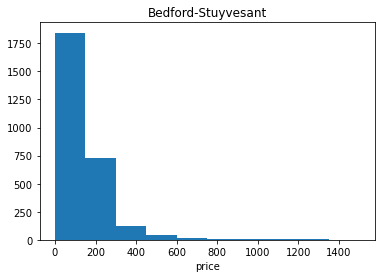

In [34]:
# plt.hist(df2_s1.price, bins=50)
plt.hist(df2_s1.price)
plt.title('Bedford-Stuyvesant')
plt.xlabel('price');

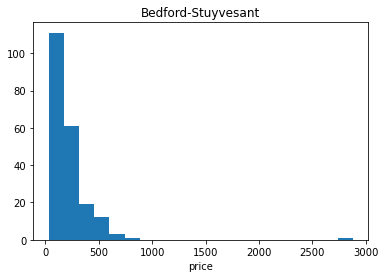

In [36]:
plt.hist(df2_s1z.price, bins=20)
plt.title('Bedford-Stuyvesant')
plt.xlabel('price');

#### Examine extremes of prices - Bed Stuy

In [38]:
top_out = np.log(df2_s1.price).max()
bot_out = np.log(df2_s1.price).min()
print(f'Log of outlier for uncorrected prices: {bot_out,top_out}');

Log of outlier for uncorrected prices: (-inf, 7.313220387090301)


In [39]:
top_outz = np.log(df2_s1z.price).max()
bot_outz = np.log(df2_s1z.price).min()
print(f'Log of outlier for uncorrected prices: {bot_outz,top_outz}');

Log of outlier for uncorrected prices: (3.4011973816621555, 7.965545573129992)


In [40]:
#prices greater than a dollar ($1)
df2_s1_corrected = df2_s1[df2_s1['price']>1]

top_out = np.log(df2_s1_corrected.price).max()
bot_out = np.log(df2_s1_corrected.price).min()
print(f'Log of outlier for corrected prices: {bot_out,top_out}');

Log of outlier for corrected prices: (2.70805020110221, 7.313220387090301)


In [41]:
df2_s1_correctedz = df2_s1z[df2_s1z['price']>1]

top_outz = np.log(df2_s1_correctedz.price).max()
bot_outz = np.log(df2_s1_correctedz.price).min()
print(f'Log of outlier for corrected prices: {bot_outz,top_outz}');

Log of outlier for corrected prices: (3.4011973816621555, 7.965545573129992)


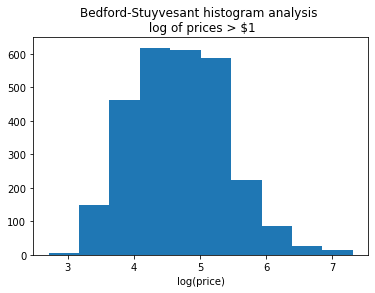

In [42]:
plt.hist(np.log(df2_s1_corrected.price))
plt.title('Bedford-Stuyvesant histogram analysis \n log of prices > \$1')
plt.xlabel('log(price)');

In [43]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

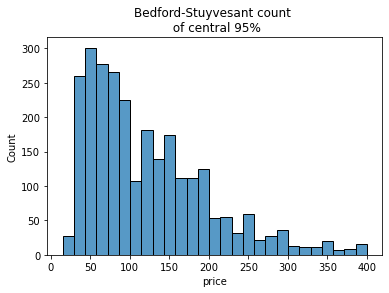

In [44]:
sb.histplot(reject_outliers(df2_s1[ df2_s1['price']>0 ]['price']))
plt.title('Bedford-Stuyvesant count \n of central 95%')
plt.show()

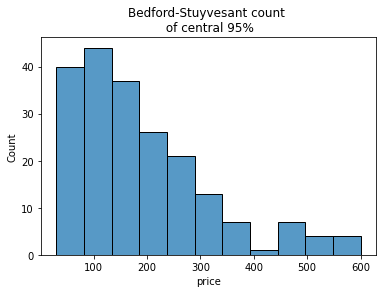

In [45]:
sb.histplot(reject_outliers(df2_s1z[ df2_s1z['price']>0 ]['price']))
plt.title('Bedford-Stuyvesant count \n of central 95%')
plt.show()

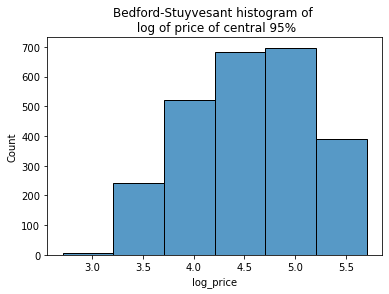

In [46]:
array = reject_outliers(reject_outliers(df2_s1[ df2_s1['price']>0 ]['price']))
array.name = 'log_price'

sb.histplot(np.log(array), binwidth=0.5)
plt.title('Bedford-Stuyvesant histogram of \n log of price of central 95%')
plt.show()

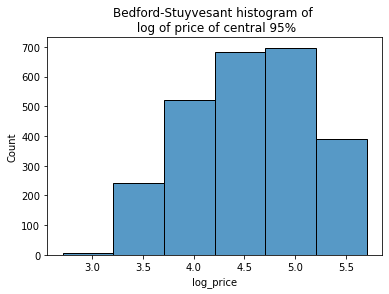

In [47]:
arrayz = reject_outliers(reject_outliers(df2_s1z[ df2_s1z['price']>0 ]['price']))
array.namez = 'log_price'

sb.histplot(np.log(array), binwidth=0.5)
plt.title('Bedford-Stuyvesant histogram of \n log of price of central 95%')
plt.show()

In [51]:
bed_stuy_meanz = np.mean(arrayz)
bed_stuy_medianz = np.median(arrayz)
bed_stuy_modez = st.mode(arrayz)

print('Bedford Stuyversant\n')
print(f'mean: ${int(bed_stuy_meanz)}')
print(f'median: ${int(bed_stuy_medianz)}')
print(f'mode: ${bed_stuy_modez.mode[0]}')
print(f'count: {len(arrayz)}')

Bedford Stuyversant

mean: $159
median: $150
mode: $90
count: 189


In [52]:
bed_stuy_mean = np.mean(array)
bed_stuy_median = np.median(array)
bed_stuy_mode = st.mode(array)

print('Bedford Stuyversant\n')
print(f'mean: ${int(bed_stuy_mean)}')
print(f'median: ${int(bed_stuy_median)}')
print(f'mode: ${bed_stuy_mode.mode[0]}')
print(f'count: {len(array)}')

Bedford Stuyversant

mean: $111
median: $98
mode: $150
count: 2540


In [53]:
log_array = np.log(array)
bed_stuy_mean = np.mean(log_array)
bed_stuy_median = np.median(log_array)
bed_stuy_mode = st.mode(log_array)

print('Bedford Stuyversant\n')
print(f'mean of log of prices: {round(bed_stuy_mean,2)}')
print(f'median of log of prices: {round(bed_stuy_median,2)} ≠ log(median)')
print(f'mode of log of prices: {round(bed_stuy_mode.mode[0],2)}')
print(f'count: {len(array)}')

Bedford Stuyversant

mean of log of prices: 4.55
median of log of prices: 4.58 ≠ log(median)
mode of log of prices: 5.01
count: 2540


In [55]:
log_arrayz = np.log(arrayz)
bed_stuy_meanz = np.mean(log_arrayz)
bed_stuy_medianz = np.median(log_arrayz)
bed_stuy_modez = st.mode(log_arrayz)

print('Bedford Stuyversant\n')
print(f'mean of log of prices: {round(bed_stuy_meanz,2)}')
print(f'median of log of prices: {round(bed_stuy_medianz,2)} ≠ log(median)')
print(f'mode of log of prices: {round(bed_stuy_modez.mode[0],2)}')
print(f'count: {len(arrayz)}')

Bedford Stuyversant

mean of log of prices: 4.88
median of log of prices: 5.01 ≠ log(median)
mode of log of prices: 4.5
count: 189


### Bed-stuy "Entire Home/ Apt"

In [56]:
df2_bedstuy = df.groupby('neighbourhood').get_group('Bedford-Stuyvesant')
df2_bedstuy;

In [57]:
df2_bedstuy_apt = df2_bedstuy.groupby('room_type').get_group('Entire home/apt')
df2_bedstuy_apt;

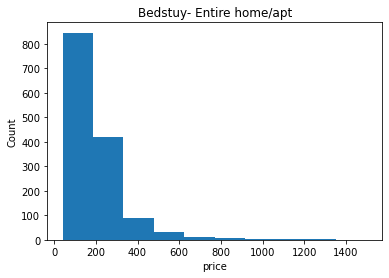

In [58]:
# plt.hist(df2_bedstuy_apt.price, bins=50)
plt.hist(df2_bedstuy_apt.price)
plt.title('Bedstuy- Entire home/apt')
plt.xlabel('price')
plt.ylabel("Count");

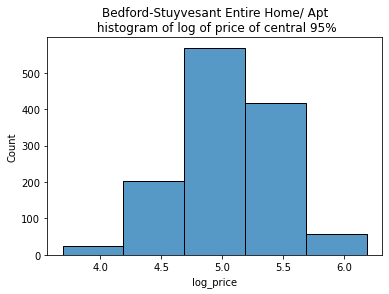

In [59]:
bedstuy_array = reject_outliers(df2_bedstuy_apt[ df2_bedstuy_apt['price']>0 ]['price'])
array = reject_outliers(bedstuy_array)
array.name = 'log_price'

sb.histplot(np.log(array), binwidth=0.5)
plt.title('Bedford-Stuyvesant Entire Home/ Apt'+\
    '\n histogram of log of price of central 95%')
plt.show()

In [60]:
log_array = np.log(array)
bed_stuy_mean = np.mean(log_array)
bed_stuy_median = np.median(log_array)
bed_stuy_mode = st.mode(log_array)

print('Bedford Stuyversant Entire Home/ Apt')
print(f'mean of log of prices: {round(bed_stuy_mean,2)}')
print(f'median of log of prices: {round(bed_stuy_median,2)} ≠ log(median)')
print(f'mode of log of prices: {round(bed_stuy_mode.mode[0],2)}')
print(f'count: {len(array)}\n')

print(f'log(median): {round(np.log(np.median(array)),2)}')

Bedford Stuyversant Entire Home/ Apt
mean of log of prices: 5.04
median of log of prices: 5.04 ≠ log(median)
mode of log of prices: 5.01
count: 1273

log(median): 5.04


In [61]:
df2_bedstuyz = d.groupby('ZipCodes').get_group(11238)
df2_bedstuyz;

In [62]:
df2_bedstuy_aptz = df2_bedstuyz.groupby('room_type').get_group('Entire home/apt')
df2_bedstuy_aptz;

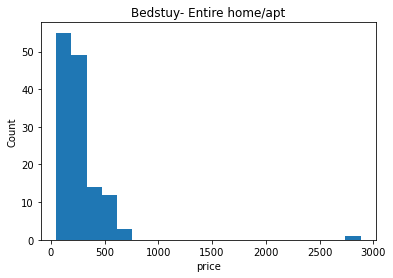

In [63]:
plt.hist(df2_bedstuy_aptz.price, bins=20)
plt.title('Bedstuy- Entire home/apt')
plt.xlabel('price')
plt.ylabel("Count");

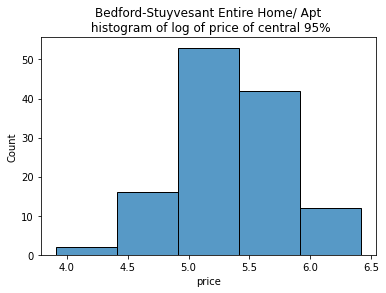

In [64]:
bedstuy_arrayz = reject_outliers(df2_bedstuy_aptz[ df2_bedstuy_aptz['price']>0 ]['price'])
arrayz = reject_outliers(bedstuy_arrayz)
array.namez = 'log_price'

sb.histplot(np.log(arrayz), binwidth=0.5)
plt.title('Bedford-Stuyvesant Entire Home/ Apt'+\
    '\n histogram of log of price of central 95%')
plt.show()

In [65]:
log_arrayz = np.log(arrayz)
bed_stuy_meanz = np.mean(log_arrayz)
bed_stuy_medianz = np.median(log_arrayz)
bed_stuy_modez = st.mode(log_arrayz)

print('Bedford Stuyversant Entire Home/ Apt')
print(f'mean of log of prices: {round(bed_stuy_meanz,2)}')
print(f'median of log of prices: {round(bed_stuy_medianz,2)} ≠ log(median)')
print(f'mode of log of prices: {round(bed_stuy_modez.mode[0],2)}')
print(f'count: {len(arrayz)}\n')

print(f'log(median): {round(np.log(np.median(arrayz)),2)}')

Bedford Stuyversant Entire Home/ Apt
mean of log of prices: 5.34
median of log of prices: 5.3 ≠ log(median)
mode of log of prices: 5.16
count: 125

log(median): 5.3


#### Williamsburg

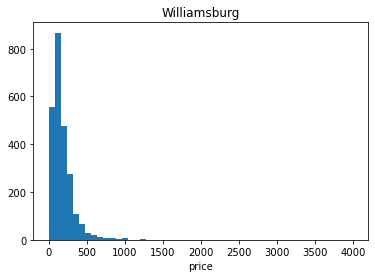

In [66]:
plt.hist(df2_s2.price, bins=50)
plt.title('Williamsburg')
plt.xlabel("price");

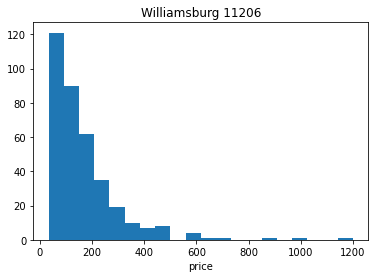

In [67]:
plt.hist(df2_s2z.price, bins=20)
plt.title('Williamsburg 11206')
plt.xlabel("price");

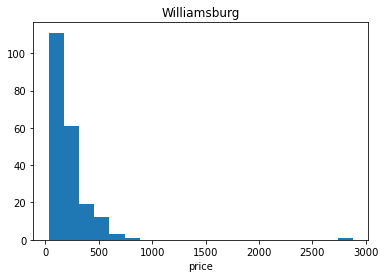

In [68]:
plt.hist(df2_s1z.price, bins=20)
plt.title('Williamsburg')
plt.xlabel('price');

#### Examine extreme of prices - Williamsburg

Log of outlier for uncorrected prices: (-inf, 8.293049139768444)
Log of outlier for corrected prices: (3.0, 8.29)


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


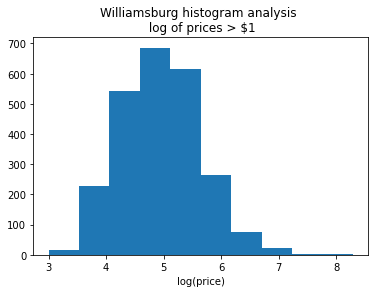

In [69]:
top_out = np.log(df2_s2.price).max()
bot_out = np.log(df2_s2.price).min()
print(f'Log of outlier for uncorrected prices: {bot_out,top_out}')

#prices greater than a dollar ($1)
df2_s2_corrected = df2_s2[df2_s2['price']>1]
top_out = np.log(df2_s2_corrected.price).max()
bot_out = np.log(df2_s2_corrected.price).min()
print(f'Log of outlier for corrected prices: {round(bot_out,2),round(top_out,2)}')

plt.hist(np.log(df2_s2_corrected.price))
plt.title('Williamsburg histogram analysis \n log of prices > \$1')
plt.xlabel('log(price)');

#### Examine extreme of prices - Williamsburg using zip codes

Log of outlier for uncorrected prices: (3.4965075614664802, 7.090076835776092)
Log of outlier for corrected prices: (3.5, 7.09)


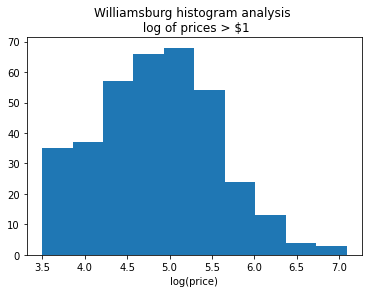

In [70]:
top_outz = np.log(df2_s2z.price).max()
bot_outz = np.log(df2_s2z.price).min()
print(f'Log of outlier for uncorrected prices: {bot_outz,top_outz}')

#prices greater than a dollar ($1)
df2_s2_correctedz = df2_s2z[df2_s2z['price']>1]
top_outz = np.log(df2_s2_correctedz.price).max()
bot_outz = np.log(df2_s2_correctedz.price).min()
print(f'Log of outlier for corrected prices: {round(bot_outz,2),round(top_outz,2)}')

plt.hist(np.log(df2_s2_correctedz.price))
plt.title('Williamsburg histogram analysis \n log of prices > \$1')
plt.xlabel('log(price)');

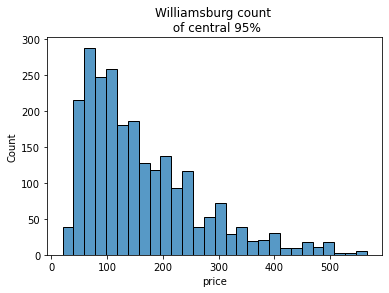

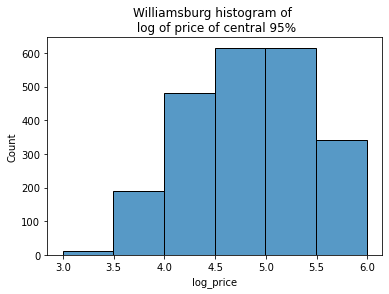

In [72]:
sb.histplot(reject_outliers(df2_s2[ df2_s2['price']>0 ]['price']))
plt.title('Williamsburg count \n of central 95%')
plt.show()

array = reject_outliers(reject_outliers(df2_s2[ df2_s2['price']>0 ]['price']))
array.name = 'log_price'

sb.histplot(np.log(array), binwidth=0.5)
plt.title('Williamsburg histogram of \n log of price of central 95%')
plt.show()

In [73]:
williamsburg_mean = np.mean(array)
williamsburg_median = np.median(array)
williamsburg_mode = st.mode(array)

print('Williamsburg\n')
print(f'mean: ${int(williamsburg_mean)}')
print(f'median: ${int(williamsburg_median)}')
print(f'mode: ${williamsburg_mode.mode[0]}')
#print(f'count: {len(array)}')

log_array = np.log(array)
williamsburg_mean = np.mean(log_array)
williamsburg_median = np.median(log_array)
williamsburg_mode = st.mode(log_array)
print('\n')
print(f'mean of natural log of prices: {round(williamsburg_mean,2)}')
print(f'median of natural log of prices: {round(williamsburg_median,2)} ≠ ln(median)')
print(f'mode of natural log of prices: {round(williamsburg_mode.mode[0],2)}')
print(f'count: {len(array)}')

Williamsburg

mean: $144
median: $125
mode: $200


mean of natural log of prices: 4.81
median of natural log of prices: 4.83 ≠ ln(median)
mode of natural log of prices: 5.3
count: 2253


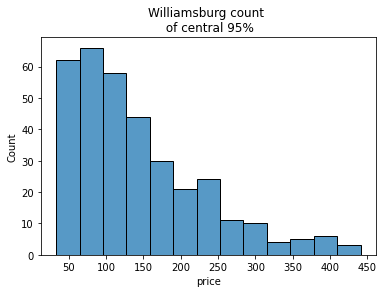

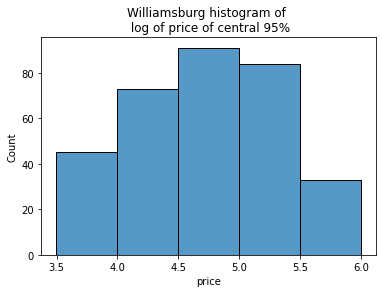

In [74]:
sb.histplot(reject_outliers(df2_s2z[ df2_s2z['price']>0 ]['price']))
plt.title('Williamsburg count \n of central 95%')
plt.show()

arrayz = reject_outliers(reject_outliers(df2_s2z[ df2_s2z['price']>0 ]['price']))
array.namez = 'log_price'

sb.histplot(np.log(arrayz), binwidth=0.5)
plt.title('Williamsburg histogram of \n log of price of central 95%')
plt.show()

In [75]:
williamsburg_mean = np.mean(arrayz)
williamsburg_median = np.median(arrayz)
williamsburg_mode = st.mode(arrayz)

print('Williamsburg\n')
print(f'mean: ${int(williamsburg_mean)}')
print(f'median: ${int(williamsburg_median)}')
print(f'mode: ${williamsburg_mode.mode[0]}')
#print(f'count: {len(array)}')

log_arrayz = np.log(arrayz)
williamsburg_meanz = np.mean(log_arrayz)
williamsburg_medianz = np.median(log_arrayz)
williamsburg_modez = st.mode(log_arrayz)
print('\n')
print(f'mean of natural log of prices: {round(williamsburg_meanz,2)}')
print(f'median of natural log of prices: {round(williamsburg_medianz,2)} ≠ ln(median)')
print(f'mode of natural log of prices: {round(williamsburg_modez.mode[0],2)}')
print(f'count: {len(arrayz)}')

Williamsburg

mean: $128
median: $109
mode: $38


mean of natural log of prices: 4.7
median of natural log of prices: 4.7 ≠ ln(median)
mode of natural log of prices: 3.64
count: 326


### Williamsburg "Entire Home/ Apt"

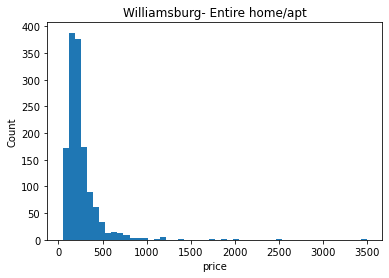

In [76]:
df2_williamsburg = df.groupby('neighbourhood').get_group('Williamsburg')
df2_williamsburg_apt = df2_williamsburg.groupby('room_type').get_group('Entire home/apt')
plt.hist(df2_williamsburg_apt.price, bins=50)
plt.title('Williamsburg- Entire home/apt')
plt.xlabel('price')
plt.ylabel("Count");

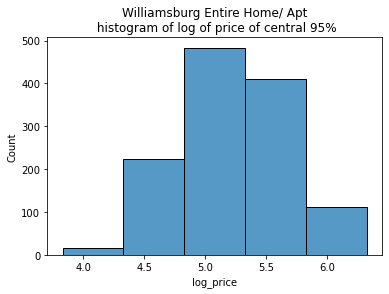

In [77]:
williamsburg_array = reject_outliers(df2_williamsburg_apt[ df2_williamsburg_apt['price']>0 ]['price'])
array = reject_outliers(williamsburg_array)
array.name = 'log_price'

sb.histplot(np.log(array), binwidth=0.5)
plt.title('Williamsburg Entire Home/ Apt'+\
    '\n histogram of log of price of central 95%')
plt.show()

In [78]:
log_array = np.log(array)
williamsburg_mean = np.mean(log_array)
williamsburg_median = np.median(log_array)
williamsburg_mode = st.mode(log_array)

print('Williamsburg Entire Home/ Apt\n')
print(f'mean of log of prices: {round(williamsburg_mean,2)}')
print(f'median of log of prices: {round(williamsburg_median,2)} ≠ log(median)')
print(f'mode of log of prices: {round(williamsburg_mode.mode[0],2)}')
print(f'count: {len(array)}')

Williamsburg Entire Home/ Apt

mean of log of prices: 5.25
median of log of prices: 5.28 ≠ log(median)
mode of log of prices: 5.3
count: 1244


### Williamsburg "Entire Home/ Apt" with zipcodes

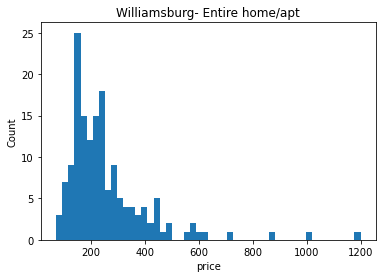

In [85]:
df2_williamsburgz = d.groupby('ZipCodes').get_group(11206)
df2_williamsburg_aptz = df2_williamsburgz.groupby('room_type').get_group('Entire home/apt')
plt.hist(df2_williamsburg_aptz.price, bins=50)
plt.title('Williamsburg- Entire home/apt')
plt.xlabel('price')
plt.ylabel("Count");

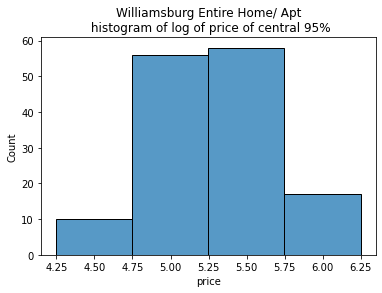

In [86]:
williamsburg_arrayz = reject_outliers(df2_williamsburg_aptz[ df2_williamsburg_aptz['price']>0 ]['price'])
arrayz = reject_outliers(williamsburg_arrayz)
array.name = 'log_price'

sb.histplot(np.log(arrayz), binwidth=0.5)
plt.title('Williamsburg Entire Home/ Apt'+\
    '\n histogram of log of price of central 95%')
plt.show()

In [87]:
log_arrayz = np.log(arrayz)
williamsburg_meanz = np.mean(log_arrayz)
williamsburg_medianz = np.median(log_arrayz)
williamsburg_modez = st.mode(log_arrayz)

print('Williamsburg Entire Home/ Apt\n')
print(f'mean of log of prices: {round(williamsburg_meanz,2)}')
print(f'median of log of prices: {round(williamsburg_medianz,2)} ≠ log(median)')
print(f'mode of log of prices: {round(williamsburg_modez.mode[0],2)}')
print(f'count: {len(arrayz)}')

Williamsburg Entire Home/ Apt

mean of log of prices: 5.31
median of log of prices: 5.32 ≠ log(median)
mode of log of prices: 5.01
count: 141


#### Harlem

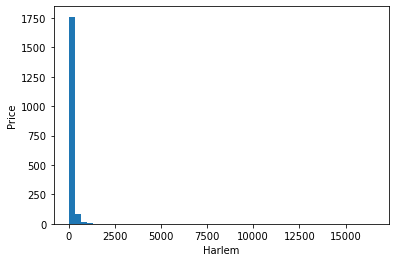

In [79]:
plt.hist(df2_s3.price,bins = 50)
plt.xlabel('Harlem')
plt.ylabel("Price");

#### Harlem with ZipCodes

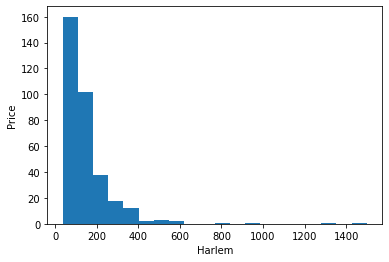

In [89]:
plt.hist(df2_s3z.price,bins = 20)
plt.xlabel('Harlem')
plt.ylabel("Price");

#### Examine extreme of prices - Harlem

Log of outlier for uncorrected prices: (2.3, 9.71)
Log of outlier for corrected prices: (2.3, 9.71)


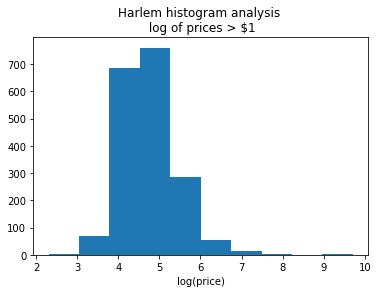

In [90]:
top_out = np.log(df2_s3.price).max()
bot_out = np.log(df2_s3.price).min()
print(f'Log of outlier for uncorrected prices: {round(bot_out,2),round(top_out,2)}')

#prices greater than a dollar ($1)
df2_s3_corrected = df2_s3[df2_s3['price']>1]
top_out = np.log(df2_s3_corrected.price).max()
bot_out = np.log(df2_s3_corrected.price).min()
print(f'Log of outlier for corrected prices: {round(bot_out,2),round(top_out,2)}')

plt.hist(np.log(df2_s3_corrected.price))
plt.title('Harlem histogram analysis \n log of prices > \$1')
plt.xlabel('log(price)');

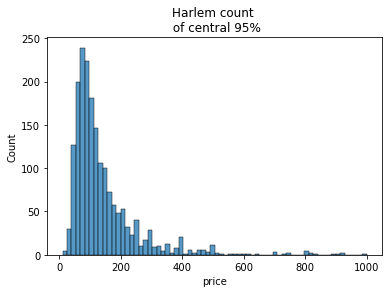

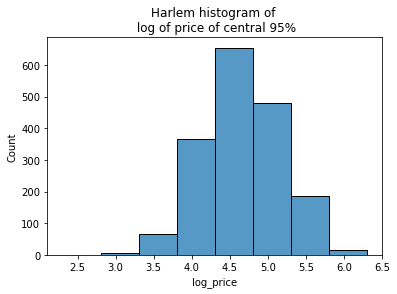

In [91]:
sb.histplot(reject_outliers(df2_s3[ df2_s3['price']>0 ]['price']))
plt.title('Harlem count \n of central 95%')
plt.show()

array = reject_outliers(reject_outliers(df2_s3[ df2_s3['price']>0 ]['price']))
array.name = 'log_price'

sb.histplot(np.log(array), binwidth=0.5)
plt.title('Harlem histogram of \n log of price of central 95%')
plt.show()

In [92]:
harlem_mean = np.mean(array)
harlem_median = np.median(array)
harlem_mode = st.mode(array)

print('Harlem\n')
print(f'mean: ${int(harlem_mean)}')
print(f'median: ${int(harlem_median)}')
print(f'mode: ${harlem_mode.mode[0]}')
#print(f'count: {len(array)}')

log_array = np.log(array)
harlem_mean = np.mean(log_array)
harlem_median = np.median(log_array)
harlem_mode = st.mode(log_array)
print('\n')
print(f'mean of natural log of prices: {round(harlem_mean,2)}')
print(f'median of natural log of prices: {round(harlem_median,2)} ≠ ln(median)')
print(f'mode of natural log of prices: {round(harlem_mode.mode[0],2)}')
print(f'count: {len(array)}')

Harlem

mean: $121
median: $100
mode: $100


mean of natural log of prices: 4.66
median of natural log of prices: 4.61 ≠ ln(median)
mode of natural log of prices: 4.61
count: 1774


Log of outlier for uncorrected prices: (3.56, 7.31)
Log of outlier for corrected prices: (3.56, 7.31)


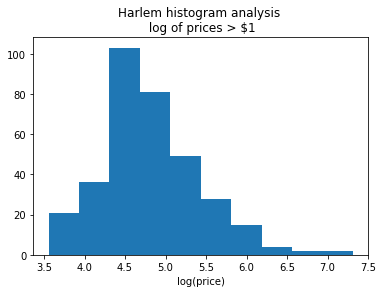

In [93]:
top_outz = np.log(df2_s3z.price).max()
bot_outz = np.log(df2_s3z.price).min()
print(f'Log of outlier for uncorrected prices: {round(bot_outz,2),round(top_outz,2)}')

#prices greater than a dollar ($1)
df2_s3_correctedz = df2_s3z[df2_s3z['price']>1]
top_outz = np.log(df2_s3_correctedz.price).max()
bot_outz = np.log(df2_s3_correctedz.price).min()
print(f'Log of outlier for corrected prices: {round(bot_outz,2),round(top_outz,2)}')

plt.hist(np.log(df2_s3_correctedz.price))
plt.title('Harlem histogram analysis \n log of prices > \$1')
plt.xlabel('log(price)');

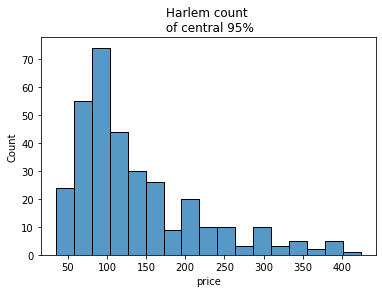

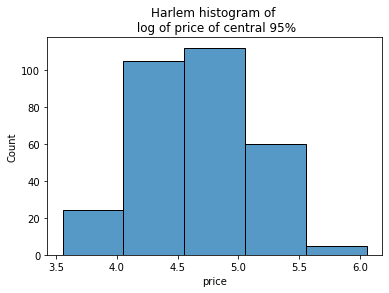

In [94]:
sb.histplot(reject_outliers(df2_s3z[ df2_s3z['price']>0 ]['price']))
plt.title('Harlem count \n of central 95%')
plt.show()

arrayz = reject_outliers(reject_outliers(df2_s3z[ df2_s3z['price']>0 ]['price']))
array.namez = 'log_price'

sb.histplot(np.log(arrayz), binwidth=0.5)
plt.title('Harlem histogram of \n log of price of central 95%')
plt.show()

In [95]:
harlem_meanz = np.mean(arrayz)
harlem_medianz = np.median(arrayz)
harlem_modez = st.mode(arrayz)

print('Harlem\n')
print(f'mean: ${int(harlem_meanz)}')
print(f'median: ${int(harlem_medianz)}')
print(f'mode: ${harlem_modez.mode[0]}')
#print(f'count: {len(array)}')

log_arrayz = np.log(arrayz)
harlem_meanz = np.mean(log_arrayz)
harlem_medianz = np.median(log_arrayz)
harlem_modez = st.mode(log_arrayz)
print('\n')
print(f'mean of natural log of prices: {round(harlem_meanz,2)}')
print(f'median of natural log of prices: {round(harlem_medianz,2)} ≠ ln(median)')
print(f'mode of natural log of prices: {round(harlem_modez.mode[0],2)}')
print(f'count: {len(arrayz)}')

Harlem

mean: $119
median: $102
mode: $100


mean of natural log of prices: 4.69
median of natural log of prices: 4.63 ≠ ln(median)
mode of natural log of prices: 4.61
count: 306


### Harlem "Entire Home/ Apt"

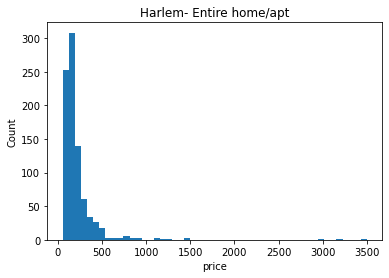

In [96]:
df2_harlem = df.groupby('neighbourhood').get_group('Harlem')
df2_harlem_apt = df2_harlem.groupby('room_type').get_group('Entire home/apt')
plt.hist(df2_harlem_apt.price, bins=50)
plt.title('Harlem- Entire home/apt')
plt.xlabel('price')
plt.ylabel("Count");

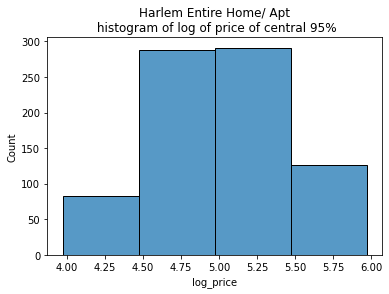

In [97]:
harlem_array = reject_outliers(df2_harlem_apt[ df2_harlem_apt['price']>0 ]['price'])
array = reject_outliers(harlem_array)
array.name = 'log_price'

sb.histplot(np.log(array), binwidth=0.5)
plt.title('Harlem Entire Home/ Apt'+\
    '\n histogram of log of price of central 95%')
plt.show()

In [98]:
log_array = np.log(array)
harlem_mean = np.mean(log_array)
harlem_median = np.median(log_array)
harlem_mode = st.mode(log_array)

print('Harlem Entire Home/ Apt\n')
print(f'mean of log of prices: {round(harlem_mean,2)}')
print(f'median of log of prices: {round(harlem_median,2)} ≠ log(median)')
print(f'mode of log of prices: {round(harlem_mode.mode[0],2)}')
print(f'count: {len(array)}')

Harlem Entire Home/ Apt

mean of log of prices: 5.01
median of log of prices: 5.01 ≠ log(median)
mode of log of prices: 5.01
count: 789


#### Harlem Entire Home/Apt using ZipCodes

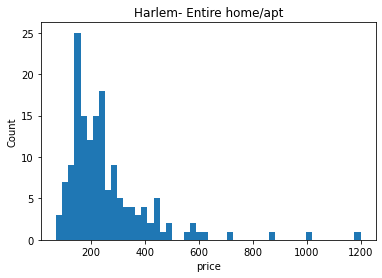

In [99]:
df2_harlemz = d.groupby('ZipCodes').get_group(11206)
df2_harlem_aptz = df2_harlemz.groupby('room_type').get_group('Entire home/apt')
plt.hist(df2_harlem_aptz.price, bins=50)
plt.title('Harlem- Entire home/apt')
plt.xlabel('price')
plt.ylabel("Count");

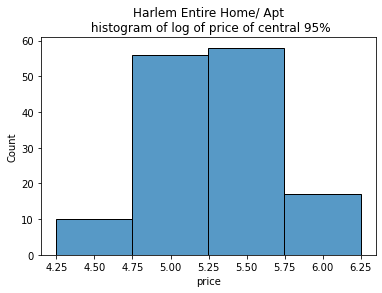

In [100]:
harlem_arrayz = reject_outliers(df2_harlem_aptz[ df2_harlem_aptz['price']>0 ]['price'])
arrayz = reject_outliers(harlem_arrayz)
array.name = 'log_price'

sb.histplot(np.log(arrayz), binwidth=0.5)
plt.title('Harlem Entire Home/ Apt'+\
    '\n histogram of log of price of central 95%')
plt.show()

In [101]:
log_arrayz = np.log(arrayz)
harlem_meanz = np.mean(log_arrayz)
harlem_medianz = np.median(log_arrayz)
harlem_modez = st.mode(log_arrayz)

print('Harlem Entire Home/ Apt\n')
print(f'mean of log of prices: {round(harlem_meanz,2)}')
print(f'median of log of prices: {round(harlem_medianz,2)} ≠ log(median)')
print(f'mode of log of prices: {round(harlem_modez.mode[0],2)}')
print(f'count: {len(arrayz)}')

Harlem Entire Home/ Apt

mean of log of prices: 5.31
median of log of prices: 5.32 ≠ log(median)
mode of log of prices: 5.01
count: 141


#### Interpretation

The aim was to get a normally distributed curve for our assumptions in obtaining a mean price per night. Without correcting for outliers, the data seems to approach a logarithmic or skewed normally distributed curve, in which case taking the median or mode for the optimum price would be most appropriate. We choose the mode, since this measure is more stable as it directly depends on the y-axis of the histogram where as the mean and median directly depends on the x-axis.

### Proportion of AirBNB Listings by Borough and Room Type in NYC

The 1st pie chart shows 95% of the AirBnB listings are in Manhattan, Brooklyn and Queens. Brooklyn and Staten Island make up the remaining listings. Manhattan and Brooklyn alone make up neary 80% of the listings.

The 2nd pie chart shows the listings distributed by room type. Most of the observations consist of entire home / apartments, or private rooms. Hotel and shared rooms are an insignificant proportion of the distribution.

In [ ]:
#Create a pie chart showing the percentage of listings per bourrough.
df1 = df.neighbourhood_group.value_counts()
df1.plot.pie(autopct="%.1f%%")
plt.show()

df2 = df.room_type.value_counts()
df2.plot.pie(autopct="%.1f%%")
plt.show()

### NYC AirBNB Listing Price Statistics by Borough

The table and box/whisker plots above provide illustration of the frequency, price statistics, and price distribution by neighborhood group or burrough in New York City. There is wide variability in the observations, with standard deviations consistently higher than the mean for each burrough. Mean prices are consistently higher than the median price, which suggest the prevalance of high values or outliers in the dataset that are pulling up the average. Average prices are highest in Manhattan, Brooklyn, and Queens respectively.

In [ ]:
#Display the table of price statistics and counts by New York City burrough.
display(df.groupby('neighbourhood_group').aggregate({'neighbourhood_group':'count',
                                    'price':['mean','median','std','min','max']}))

#Plot boxplot with outliers turned off.
sb.boxplot(y = df['price'], 
            x = df['neighbourhood_group'], 
            showfliers = False)
plt.title('Borough boxplot corrected \n for interquartile rule')
plt.show()

sb.boxplot(y = df['price'], x = df['neighbourhood_group'], showfliers = True)
plt.title('Borough boxplot uncorrected')
plt.show()

### NYC AirBNB Listing Price Statistics by Room Type
The table and box/whisker plots above provide illustration of the frequency, price statistics, and price distribution by room type in New York City. As in the distribution by borough section, there is wide variuability with standard deviations consistently higher than the mean for each burrough (Hotel rooms being the exception). Mean prices are also consistently higher than the median price, which suggest the prevalance of high values or outliers in the dataset that are pulling up the average. Comparisons of the 1st boxplot (corrected for outliers) with the second (not corrected for outliers bear this out.

#### Major Room Type Categories
These categories encompass 98% of the listings and are likely to be more useful for informing business decisions.
- Entire home/apt: Entire residences make up 57% of the dataset and are the category with the second highest average price. Prices range from \\$10 to \\$15K which could be indicative of data errors and/ or outliers.
- Private room: Private rooms constitute 42% of the listings in the data and are the category with the third highest average price. Prices range from \\$10 to \\$16.5K which could be indicative of data errors and/ or outliers.

#### Minor Room Type Categories
Categories that are a significantly smaller number of the overall listings in the dataset. They are less likely to be useful for informing business decisions.
- Shared room: Shared rooms constitute 1.4% of the listings with the lowest average price of all room type categories. Prices range from \\$10 to \\$10K which seems to indicate data entry errors and/or outliers.
- Hotel room: Hotel rooms seem to have the highest average price and the least number of observations. This is the only category where the standard deviation is less than the mean, which suggest a more limited number of high priced outliers.


In [ ]:
#Display the table of price statistics and counts by New York City burrough.
display(df.groupby('room_type').aggregate({'room_type':'count','price':['mean', 'median','std','min','max']}))

#Plot boxplot with outliers turned off.
sb.boxplot(y = df['price'], x = df['room_type'], showfliers = False)
plt.title('Room Type boxplot corrected \n for interquartile rule')
plt.show()
sb.boxplot(y = df['price'], x = df['room_type'], showfliers = True,saturation=0.75)
plt.title('Room Type boxplot uncorrected')
plt.show()

### AirBNB Listings Statistics by Borough and Room Type in NYC
The listings dataset was aggregated by borough and room type for statistical analysis. The results underscore the need to remove outliers and illogical values from the data.

In [ ]:
#Show price statistics by neighborhood group and room type
df_borrough = df[[ 'neighbourhood_group', 'room_type','price']]
display(df_borrough.groupby(['neighbourhood_group', 'room_type']).aggregate({'count',
    'mean', 'median','std', 'min', 'max'}))

### Correlation Matrix
A correlation matrix was conducted for the listings data. At this point, most of the factors appear to be weakly correlated with price, which is the primary variable of concern.

In [ ]:
df.corr(method='pearson')

## Map Visualization of the Distribution of Price by Neighborhood in NYC

This section provides analysis on the distribution of price by neighborhood. The mean price by neighborhood was computed from the data, keyed on a geojson file and incorporated into a folium map. There are several clusters of relatively higher prices, but the most significant one is around the Manhattan area.

## Conclusion and TakeAways

- Average listing prices for Manhattan tend to be the highest, followed by Brooklyn, Queens, Staten Island, and the Bronx. Most of the listings are in Manhattan, Brooklyn, and Queens.

- Entire residences/apartments and private rooms comprise ~97% of the listings here. Hotels and shared rooms are less than 2% of the dataset. Hotels tend to have the highest average price followed by residences, private rooms, and lastly shared rooms. Any predictive model underlying algorithms should be differentiated by room type. In terms of business analytics utility, residences and private rooms seem to be the most promising, while hotels and shared rooms may be less useful due to the relatively limited amount of data.
- The variability in the data is significant. The data should be disaggregated by room type, and all values greater than the 3rd quartile + (1.5 * IQR) should be removed. also, all zero values should also be removed.
- It is hypothesized that properties closer to either Manhattan or other significant attractions will have higher list prices ceteris paribus.

In [ ]:
# import geojson file
with open('./neighbourhoods.geojson') as f:
    hood_json = json.load(f)

for i in hood_json["features"]:
    i["id"] = i["properties"]["neighbourhood"]

In [ ]:
# Aggregate listing data by neighborhood
df_hood = df.iloc[:,[0,4,5,6,7,9]]
df_grp_by_hood = df_hood.groupby('neighbourhood').agg({'latitude':['mean'],'longitude':['mean'], 'price': ['mean']})
df_grp_by_hood.columns = ['lat','long','price']
df_grp_by_hood = df_grp_by_hood.reset_index()

In [ ]:
# Develop Choropleth map 
m = folium.Map(location =[df_grp_by_hood["lat"].mean(),df_grp_by_hood["long"].mean()],
                zoom_start = 10)

folium.GeoJson(hood_json, name="geojson").add_to(m)
folium.Choropleth(
    geo_data= hood_json,
    data=df_grp_by_hood,
    columns=['neighbourhood', 'price'],
    key_on='feature.properties.neighbourhood',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='price'
).add_to(m)
m


# Regression analysis
- What price should be charged based on rental location/ characteristics?

### Clean dataset

In [ ]:
hood_price_obj.mean()

In [ ]:
neighborhood = df['neighbourhood'].unique()
neighborhood.sort()
modes=[st.mode(hood_price_obj.get_group(arr)).mode[0][-1] for arr in neighborhood]
counts=[st.mode(hood_price_obj.get_group(arr)).count[0][0] for arr in neighborhood]

neighborhood = df['neighbourhood'].unique()
neighborhood.sort()

df_aux = hood_price_obj.mean()
df_aux['mean']  = df_aux['price'].round(2)
df_aux['median'] = hood_price_obj.median().round(2)
df_aux['mode'] = pd.DataFrame(np.array(modes), index=df_aux.index)
df_aux['count'] = pd.DataFrame(np.array(counts), index=df_aux.index)
df_aux

In [ ]:
dat = df.loc[:,'neighbourhood_group':'number_of_reviews_ltm']
dat[['mean_price']] = None
dat[['mode_price']] = None
dat[['median_price']] = None
dat[['count_hood']] = None

for n in df_aux.index:
    updated = dat['neighbourhood']==n
    dat.loc[updated, 'mean_price'] = df_aux.loc[n,'mean']
    
    updated = dat['neighbourhood']==n
    dat.loc[updated, 'mode_price'] = df_aux.loc[n,'mode']
    
    updated = dat['neighbourhood']==n
    dat.loc[updated, 'median_price'] = df_aux.loc[n,'median']
    
    updated = dat['neighbourhood']==n
    dat.loc[updated, 'count_hood'] = df_aux.loc[n,'count']
    
dat

#### *analyze neighborhoods that have more than 30 observations*
https://machinelearningmastery.com/a-gentle-introduction-to-the-bootstrap-method/

In [ ]:
dat_strap = dat[dat['count_hood']>30]
dat_strap

## Logistic Regression

In [ ]:
update = dat_strap['price'] >= dat_strap['mode_price'] 
target = pd.get_dummies(update).iloc[:,0]

### Fit model with Data

In [ ]:
#Numerical type, same column size unless int

X = pd.DataFrame({'Const':1,
#     'neighbourhood_group':pd.get_dummies(dat_strap['neighbourhood_group']),#.iloc[:,0],
#     'neighbourhood':pd.get_dummies(dat_strap['neighbourhood']),#.iloc[:,0],
#     'room_type':pd.get_dummies(dat_strap['room_type']),#.iloc[:,0],
    'price':dat_strap['price'],#.iloc[:,0],
    'minimum_nights':dat_strap['minimum_nights'],#.iloc[:,0],
    'number_of_reviews':dat_strap['number_of_reviews'],#.iloc[:,0],
    'availability_365':dat_strap['availability_365'],#.iloc[:,0],
    'number_of_reviews_ltm':dat_strap['number_of_reviews_ltm']})

In [ ]:
# Describe the logistic model
mod = sm.Logit(target,X)

# Fit model
fit = mod.fit()

# Summarize model
fit.summary()

In [ ]:
fit.params

It is not straight forward to interpret coefficients of the logistic regression. Here, we show average marginal effects.

In [ ]:
# Calculate average marginal effects
mfx = fit.get_margeff()
print(mfx.summary())

Marginal effects for numerical types are low! Try classification analyses.

In [ ]:
def plot_decision_boundary(model,X,y):
    padding=0.15
    res=0.1
    
    #max and min values of x and y of the dataset
    x_min,x_max=X[:,0].min(), X[:,0].max()
    y_min,y_max=X[:,1].min(), X[:,1].max()
    
    #range of x's and y's
    x_range=x_max-x_min
    y_range=y_max-y_min
    
    #add padding to the ranges
    x_min -= x_range * padding
    y_min -= y_range * padding
    x_max += x_range * padding
    y_max += y_range * padding

    #create a meshgrid of points with the above ranges
    xx,yy=np.meshgrid(np.arange(x_min,x_max,res),np.arange(y_min,y_max,res))
    
    #use model to predict class at each point on the grid
    #ravel turns the 2d arrays into vectors
    #c_ concatenates the vectors to create one long vector on which to perform prediction
    #finally the vector of prediction is reshaped to the original data shape.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])   
    Z = Z.reshape(xx.shape)
    
    #plot the contours on the grid
    plt.figure(figsize=(8,6))
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    
    #plot the original data and labels
    plt.scatter(X[:,0], X[:,1], s=35, c=y, cmap=plt.cm.Spectral, 
                label='sub optimal price')

In [ ]:
target

In [ ]:
model = LogisticRegression(solver='newton-cg')
model.fit(X[['minimum_nights','number_of_reviews']].values, target.values)

samp = X.sample(100)
plot_decision_boundary(model,
    samp[['minimum_nights','number_of_reviews']].values,
                       pd.DataFrame(target).loc[samp.index,:].values)
plt.title('Decision Boundary- Logistic\n Regression sample of 100')
plt.xlabel('minimum_nights')
plt.ylabel('number_of_reviews')
plt.legend()

# Data analysis 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sidetable as stb
import numpy as np
import seaborn as sns
from scipy import stats as st
import statsmodels as sts
%matplotlib inline

In [ ]:
csv_URL = "http://data.insideairbnb.com/united-states/ny/new-york-city/2022-09-07/visualisations/listings.csv"
df2 = pd.read_csv(csv_URL)


In [ ]:
print(df2.neighbourhood.nunique())
print(df2.neighbourhood_group.nunique())
print(df2.room_type.nunique())
print(df2.last_review.nunique)

In [ ]:
# nominal data doesn't have any impact on price, so dropped few columns
df2 = df2.drop(["neighbourhood","last_review","host_name","host_id","id","license",'reviews_per_month','license','name'],axis=1)

In [ ]:
df2 = df2.drop(['latitude','longitude'],axis=1)

In [ ]:
df2.shape

In [ ]:
df2.describe()

In [ ]:
bins = np.arange(df2.price.min(), 2000+20, 20)

In [ ]:
plt.hist(df2.price,bins=bins)

In [ ]:
df2 = df2[df2['price'] <= 500]

In [ ]:
df2['price'].describe(percentiles=[0.1, 0.2, 0.3, 0.5])

In [ ]:
plt.hist(df2.price)

Naive bayes algorithm solves classification problems. But in this dataset classification won't be an easy task. With regression we can predict price, dataset we filtered for our analysis doesn't look appropriate for predicting mode price of any new neighbourhood. However, we tried to predict the price.

In [ ]:
def add_column(df2_p):
    price_class=[]
    for i in df2_p:
        if i<250:
            price_class.append(1)
        else:
            price_class.append(0)
    price_class = pd.Series(price_class)
    return price_class

 Dividing the price's into 2 classes using above and adding an new column 'PriceClass'

In [ ]:
df2=pd.concat([df2,pd.DataFrame(add_column(df2.price))],axis=1)

In [ ]:
# added Price class column for classification algorithm
df2.rename(columns={0:'PriceClass'},inplace=1)

In [ ]:
df2.dropna(inplace=True)

In [ ]:
df2.info()

In [ ]:
#for classification
import sklearn as skl
from sklearn.naive_bayes import MultinomialNB
X = pd.get_dummies(data=df2.drop('price', axis=1), 
                   columns=['room_type','neighbourhood_group'],
                   prefix = ['room_type','neighbourhood_group'])

X.info()

In [ ]:
# for regression
import sklearn as skl
from sklearn.naive_bayes import MultinomialNB
X_reg = pd.get_dummies(data=df2, 
                   columns=['room_type','neighbourhood_group'],
                   prefix = ['room_type','neighbourhood_group'])

X_reg.info()

In [ ]:
y_reg = df2['price'].copy()
y_reg.head()

In [ ]:
X.describe().transpose()

In [ ]:
y = df2['PriceClass'].copy()
y.head()

In [ ]:
#for classification
from sklearn.model_selection import train_test_split

# 20-80%  split
train_y,test_y,train_X,test_X = train_test_split(y, X,
                                                 test_size=0.2,
                                                 random_state=123)

In [ ]:
# for regression
from sklearn.model_selection import train_test_split

# 20-80% simple split
train_y_reg,test_y_reg,train_X_reg,test_X_reg = train_test_split(y_reg, X_reg,
                                                 test_size=0.2,
                                                 random_state=123)

In [ ]:
train_X_reg.shape

In [ ]:
train_X.shape

In [ ]:
from sklearn import preprocessing

# Create a scaler to do the transformation
scaler = preprocessing.MinMaxScaler().fit(train_X)

In [ ]:
from sklearn import preprocessing

# Create a scaler_reg to do the transformation
scaler_reg = preprocessing.MinMaxScaler().fit(train_X_reg)

In [ ]:
# Transform training X_reg
train_X_scale_reg = scaler_reg.transform(train_X_reg)
train_X_scale_reg = pd.DataFrame(train_X_scale_reg)
train_X_scale_reg.columns = train_X_reg.columns


In [ ]:
# Transform training X
train_X_scale = scaler.transform(train_X)
train_X_scale = pd.DataFrame(train_X_scale)
train_X_scale.columns = train_X.columns


In [ ]:
# Transform test X_reg
test_X_scale_reg = scaler_reg.transform(test_X_reg)
test_X_scale_reg = pd.DataFrame(test_X_scale_reg)
test_X_scale_reg.columns = test_X_reg.columns


In [ ]:
# Transform test X
test_X_scale = scaler.transform(test_X)
test_X_scale = pd.DataFrame(test_X_scale)
test_X_scale.columns = test_X.columns


In [ ]:
print(train_X.shape)
print(train_y.shape)
print(test_y.shape)
print(test_X.shape)
print(train_y)

In [ ]:
df2.shape

In [ ]:
#K-nn Regression
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsRegressor()
from sklearn.model_selection import GridSearchCV
parameters = {"n_neighbors": range(1, 50)}
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(train_X_reg,train_y_reg)

In [ ]:
gridsearch.best_params_

In [ ]:
knn_reg=KNeighborsRegressor(4)
knn_reg.fit(train_X_reg,train_y_reg)

### The best neighbor is 4, using neighbor 4 for model prediction and calculating Accuracy score

In [ ]:
pred_y_reg=knn_reg.predict(test_X_scale_reg)

In [ ]:
print('k=4 Accuracy=',knn_reg.score(test_X_scale_reg,pred_y_reg))

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
train_preds_grid = gridsearch.predict(train_X_reg)
train_mse = mean_squared_error(train_y_reg, train_preds_grid)
train_rmse = sqrt(train_mse)
test_preds_grid = gridsearch.predict(test_X_reg)
test_mse = mean_squared_error(test_y_reg, test_preds_grid)
test_rmse = sqrt(test_mse)
print('RMSE_train:',train_rmse)

print('RMSE_test:',test_rmse)

 RSME error rates are very high. Which implies that performing K-nn regression did not show any good results.
 

In [ ]:
# scatter plot using test variables
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
xs = test_X_reg['price']
ys = test_X_reg['minimum_nights']
for x, y in zip(xs, ys):
   plt.scatter(x, y, cmap="copper")
plt.show()

In [ ]:
train_preds_grid

We performed classification based on price by converting price into 2 classes i.e less than 250 & greater than 250. 
used new variable called PriceClass to classify two classes.
There was a class imbalance for greater and lower price when we 500 as the marginal value for both the classes.
As greater than 500 very less in number compared to below 500. Majorly, in above 500 class there were very less
values away from 500 compared to values nearer 500.
To handle class imbalance values above 500 were removed as they are less in number.

In [ ]:
# function for plotting confusion matrix
import matplotlib.pyplot as plt
import numpy as np
def print_cm(cm):
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Class 1','Class 2']
    plt.title('Confusion Matrix - Test Data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']] 
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

In [ ]:
#K-NN 
from sklearn import neighbors

# KNN: K=5, default measure of distance (euclidean)
knn5 = neighbors.KNeighborsClassifier(n_neighbors=5)

In [ ]:
knn5.fit(train_X_scale, train_y)


In [ ]:
pred_y_knn5 = knn5.predict(test_X_scale)

In [ ]:
from sklearn import metrics

# Print confusion matrix
cm = metrics.confusion_matrix(test_y, pred_y_knn5)
print(cm)

In [ ]:
print_cm(cm)

In [ ]:
print(metrics.classification_report(test_y, pred_y_knn5))

Here we can see in the confusion matrix TN=1203, Tp=6051, FP=1,FN=0
Classification metrics shows the results are 100% correct
 Which implies the model is not correct fit.


In [ ]:
# Calculate classification accuracy
metrics.accuracy_score(test_y, pred_y_knn5)

In [ ]:
for k in range(20):
    k = k + 1
    knn = neighbors.KNeighborsClassifier(n_neighbors = k, 
                                         weights='uniform', 
                                         algorithm='auto')
    knn.fit(train_X_scale, train_y)
    pred_y = knn.predict(test_X_scale)
    print("AUC is ", round(metrics.roc_auc_score(test_y, pred_y)*100,2),"% for k =",k)

 # NYC AirBnB Data Principle Component Analysis

## Step-1: Import Packages,  Data Exploration & Cleaning
Intent should be to maximize information content while minimizing the number of dimensions or variables in the datset. Most of the variables in the dataframe have non null values except 'last_review', 'reviews_per_month', and 'license'. These columns are believed to have either little information value, or are believed to have other variables that would explain their effects anyway. Thus the aforementioned columns were removed. In addition all observations with zero values in the 'price' column were removed. It is assumed that the 'price'  will be the primary variable of interest.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import seaborn as sb
import plotly.express as px

In [ ]:
csv_URL = "http://data.insideairbnb.com/united-states/ny/new-york-city/2022-09-07/visualisations/listings.csv"
df= pd.read_csv(csv_URL)
df.info()

In [ ]:
# remove deemed to be less than useful
df['lat_lon']= df['latitude']/df['longitude']
df = df.drop(['license', 'reviews_per_month','last_review', 'name', 'host_id','neighbourhood', 'host_name'],axis = 1)
df = df.loc[(df['price']> 0)]# Remove all zero values from the price
display(df.info())
sb.pairplot(df[['price','latitude','longitude','lat_lon']], kind="reg")
plt.show()

The pairplot was developed to gain an understanding of the relationship between 'latitiude', 'longitude', and 'price'. Based on this visualization, that correlation appears to be weak.

# Step 2: Determine & Remove the Outliers
Process was to remove all outliers larger than q3 + (1.5 * IQR), or less than or equal to the minimum. In addition the latitude and longitude columns were removed from the dataset and replaced with the transformation 'lat_lon', which is the ratio latitude to longitude. The result reduced the number of observations in the data from 39881 to 36524.

In [ ]:
df_stats = df.groupby('room_type')['price'].describe()
df_stats.reindex()
display(df_stats)

In [ ]:
# Create Table with outliers
df_stats['IQR'] = df_stats["75%"]- df_stats["25%"]
df_stats['upper_outlier'] = df_stats["75%"] + (1.5 * df_stats['IQR'])
df_stats['lower_outlier'] = df_stats["25%"] - (1.5 * df_stats['IQR'])
display(df_stats)

In [ ]:
df1 = df[(df['room_type'] == "Entire home/apt") & (df['price']>=10) & (df['price']<= 496)]
df2 = df[(df['room_type'] == "Private room") & (df['price']>= 10) & (df['price']<= 192)]
df3 = df[(df['room_type'] == "Shared room") & (df['price']>= 10) & (df['price']<= 167)] 
df4 = df[(df['room_type'] == "Hotel room") & (df['price']>= 100) & (df['price']<= 865)]
frames = [df1, df2, df3, df4]
df = pd.concat(frames)

display(df.groupby('neighbourhood_group')['price'].describe())
display(df.groupby('room_type')['price'].describe())
sb.boxplot(y = df['price'], x = df['room_type'])
plt.show()
sb.boxplot(y = df['price'], x = df['neighbourhood_group'])
plt.show()
display(df.info())
display(df.corr())

In [ ]:
df_select = df[['price','lat_lon','neighbourhood_group','room_type', 'minimum_nights', 'number_of_reviews','calculated_host_listings_count','availability_365','number_of_reviews_ltm']]
df_select.info()

# Step 3:  Incorporate Categorical Variables into the Data and Scale the Dataset
The purpose of this step was to incorporate room type and neighborhood or NYC burrough into the dataset as "dummy variables" using one hot encoding. Also conducted during this step was a targeted correlation between price and the remaining variables.The strongest positive correlations were room types of 'Entire home/apt', neighborhood groups of 'Manhattan' and 365 day availability. Strongest negative correlation was a room type of "Private room". Finally the dataset was normalized.

In [ ]:
 # One-hot encode the neighbourhood_group column
dfx = pd.concat([df_select,
               pd.get_dummies(df_select['neighbourhood_group'])],axis=1)


In [ ]:
 # One-hot encode the room_type column
X = pd.concat([dfx,
               pd.get_dummies(dfx['room_type'])],axis=1)
            
# Drop the original categorical column and the response variable
df = X.drop(['neighbourhood_group','room_type'], axis=1)
display(df.info())
display(df[df.columns[0:]].corr()['price'][:].sort_values(ascending=False).to_frame())

In [ ]:
X = scale(df)# Normalize the data
display(pd.DataFrame(X).describe().transpose())# Display the normalize data statistics
corr_ = pd.DataFrame(X).corr() #Display the correlation matrix for the normalized data
pd.DataFrame(corr_).style.background_gradient(cmap = 'YlOrRd')

# Step 4: Principal Component Analysis
The PCA was conducted on the normalized data and indicate the following results:
- The most important variables in the dataset are 'price', 'Manhattan', 'Entire home/apt', and 'Private room'
- The least significant variables seem to be 'Hotel room' and 'Queens'.
- Information content in the data is dispersed. There dont seem to be any significant clusters of variability. As indicated by the scree plot and the measures of the cumulative variability, you dont get above 90% of the variability explained until you get to 11 of the 16 principal components. Once you get to roughly 13 principal components, marginal variability apears to go to zero. As evidenced by the correlation matrices and the heatmaps, most of the variables could be considered to have a significant component loading depending on the dimension in which they are viewed. The practical effect of this seems to be that action taken to reduce the dimensionality of the dataset won't add any significant benefits.

In [ ]:
# Select the number of components
pca1 = PCA(n_components=16)
# Fit the PCA model
pca1.fit(X)

In [ ]:
#The amount of variance that each PC explains
var = pca1.explained_variance_ratio_
display(var)

In [ ]:
#Cumulative Variance explains
var1 = np.cumsum(np.round(pca1.explained_variance_ratio_, decimals=4)*100)
display(var1)

In [ ]:
var1 = pd.DataFrame(var1, index=np.arange(1,17))
plt.plot(var1,'-o',color='blue')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.savefig('scree_plot.png',dpi=100,bbox_inches='tight')
plt.show()

In [ ]:
# Select the number of components
pca16 = PCA(n_components=16)
pca16.fit(X)
data_pca16 = pca16.transform(X)

# Convert the numpy array to pandas DataFrame
data_pca16 = pd.DataFrame(data_pca16)
data_pca16.columns = ["PC"+str(i) for i in range(1,17)]

# Show the head of the DataFrame
display(data_pca16.head())
display(data_pca16.corr())


All pairwise combinations are cose to zero which is indicative of no multicollinearity among principal components.


In [ ]:
# Show the loadings for the 1st components
pca16.components_[[0]]

In [ ]:
corr_16 = pd.DataFrame(pca16.components_.transpose(),
             index=df.loc[:,'price':'Shared room'].columns,
             columns=["PC"+str(i) for i in range(1,17)])
display(pd.DataFrame(corr_16).style.background_gradient(cmap = 'YlOrRd'))
ax = sb.heatmap(corr_16, annot=False, cmap = 'YlOrRd', vmin = -1, vmax = 1)
plt.show()

# Technology Stack

In [ ]:
!which python

In [ ]:
!which jupyter

In [ ]:
!which python3

# Github Repository, Handles, and Evaluation

https://github.com/Naren1610/IST5520GrpProj/tree/milestone2

### IST5520GrpProj

<h4 align="left"> Ronald Adomako, adomakor412 </h3>
<h4 align="left"> Idris Dobbs, idobbs-2012 </h3>
<h4 align="left"> Narendra Chigili, Naren1610 </h3>
<h4 align="left"> Nikhil Srirama Sai, SaiNikhilPalaparthi </h3>